In [1]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
print("Path to dataset files:", path)
p = path + '/Data/genres_original'

Path to dataset files: /home/jer/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1


In [2]:
# Import libraries
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

2024-11-05 19:56:04.711628: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730854564.760146    6738 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730854564.773135    6738 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 19:56:04.821126: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load data
data = pd.read_csv(path + '/Data/features_30_sec.csv')
data['path'] = data['filename'].apply(lambda x: f"{path}/Data/images_original/{x.split('.')[0]}/{x.split('.')[0]}{x.split('.')[1]}.png")
data['genre'] = data['filename'].apply(lambda x: x.split('.')[0])
data = data[['filename', 'path', 'genre']]

In [4]:
# Split data
X_train, X_test = train_test_split(data, test_size=0.2, random_state=15)

# Data generator
datagen = ImageDataGenerator()
train_it = datagen.flow_from_dataframe(X_train, x_col="path", y_col="genre", batch_size=100)
test_it = datagen.flow_from_dataframe(X_test, x_col="path", y_col="genre", batch_size=64)

Found 799 validated image filenames belonging to 10 classes.
Found 200 validated image filenames belonging to 10 classes.


/home/jer/anaconda3/envs/cap/lib/python3.9/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


In [5]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [6]:

import torch
x = torch.randn(1).cuda()  # Moves tensor to GPU
print(x)


tensor([-1.1835], device='cuda:0')


In [7]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [8]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.18.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
I0000 00:00:1730854570.273555    6738 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2249 MB memory:  -> device: 0, name: Quadro T1000 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


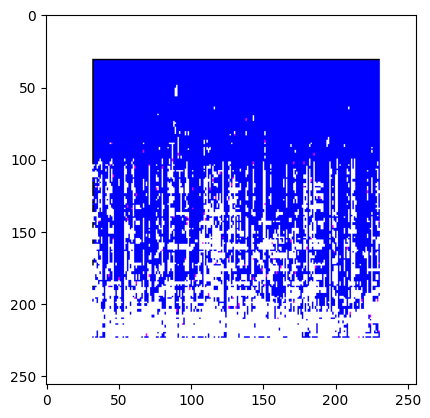

In [9]:
# Display sample
plt.imshow(next(train_it)[0][0])

# Model setup
inp = Input(shape=next(train_it)[0][0].shape)
base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=inp)
for layer in base_model.layers:
    layer.trainable = False

In [10]:
import PIL

# Model setup
inp = Input(shape=next(train_it)[0][0].shape)
base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=inp)
for layer in base_model.layers:
    layer.trainable = False

In [11]:
new_model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile model
new_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 131072)         │       524,288 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,898,762 (156.02 MB)

 Trainable params: 17,048,650 (65.04 MB)

 Non-trainable params: 23,850,112 (90.98 MB)

In [12]:
# Train model
es = EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=3)
history = new_model.fit(train_it, validation_data=test_it, epochs=50, callbacks=[es])

# Evaluate model
new_model.evaluate(test_it)

/home/jer/anaconda3/envs/cap/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


/home/jer/anaconda3/envs/cap/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_175']. Received: the structure of inputs=*
  warnings.warn(
I0000 00:00:1730854581.599127    6847 service.cc:148] XLA service 0x7f136c001920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730854581.599197    6847 service.cc:156]   StreamExecutor device (0): Quadro T1000 with Max-Q Design, Compute Capability 7.5
2024-11-05 19:56:21.842203: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730854583.040680    6847 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-05 19:56:24.636011: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 934.75MiB with freed_by_count=0. 

5/8 ━━━━━━━━━━━━━━━━━━━━ 1s 398ms/step - accuracy: 0.1483 - loss: 2.9047

2024-11-05 19:56:50.570586: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 925.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-05 19:56:51.783106: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng13{} for conv (f32[99,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[99,3,256,256]{3,2,1,0}, f32[64,3,7,7]{3,2,1,0}, f32[64]{0}), window={size=7x7 stride=2x2 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-05 19:56:52.139193: E external/local_xla/xla/service/slow_operati

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1720 - loss: 2.7791

2024-11-05 19:57:18.426821: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,64,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,64,64]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-05 19:57:21.079488: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,128,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,128,32,32]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActi

8/8 ━━━━━━━━━━━━━━━━━━━━ 83s 7s/step - accuracy: 0.1772 - loss: 2.7527 - val_accuracy: 0.2050 - val_loss: 9.2736
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 893ms/step - accuracy: 0.3523 - loss: 1.9139 - val_accuracy: 0.3000 - val_loss: 3.5305
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 788ms/step - accuracy: 0.3611 - loss: 1.7502 - val_accuracy: 0.4400 - val_loss: 2.2261
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 892ms/step - accuracy: 0.4365 - loss: 1.5130 - val_accuracy: 0.4600 - val_loss: 1.8374
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 921ms/step - accuracy: 0.5507 - loss: 1.3972 - val_accuracy: 0.4700 - val_loss: 1.6076
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 921ms/step - accuracy: 0.5752 - loss: 1.2668 - val_accuracy: 0.5050 - val_loss: 1.4823
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 898ms/step - accuracy: 0.5373 - loss: 1.3281 - val_accuracy: 0.5200 - val_loss: 1.4010
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 884ms/step - accuracy: 0.6303 - loss: 1.0767 - val_accuracy: 0.5450 - val_loss: 1.3285
Epoch

[1.1464474201202393, 0.6399999856948853]

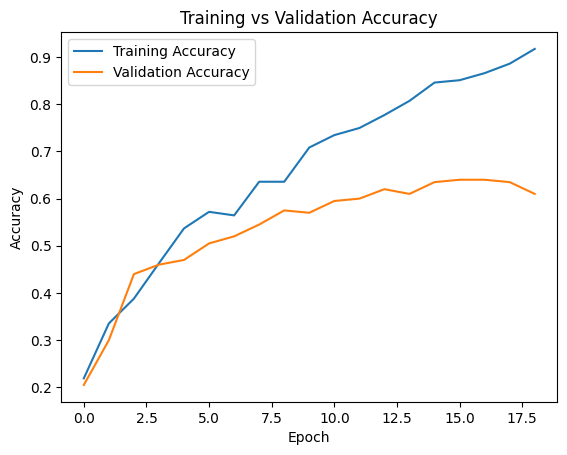

In [13]:
# Access training and validation accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
